# Part 1: Download project materials.

In [ ]:
! git clone https://github.com/ntqq/yolov3_ml2021/
!mv yolov3_ml2021/* './'

Cloning into 'yolov3_ml2021'...
remote: Enumerating objects: 321, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (317/317), done.
remote: Total 321 (delta 55), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (321/321), 12.47 MiB | 22.49 MiB/s, done.
Resolving deltas: 100% (55/55), done.


# Part 2: Download yolov3 weights and convert it to tensorflow keras .h5 format.

In [ ]:
!wget wget https://pjreddie.com/media/files/yolov3.weights

--2021-12-22 06:44:53--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2021-12-22 06:44:53--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  46.0MB/s    in 5.2s    

2021-12-22 06:44:58 (45.1 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

FINISHED --2021-12-22 06:44:58--
Total wall clock time: 5.6s
Downloaded: 1 files, 237M in 5.2s (45.1 MB/s)


In [ ]:
%run keras_yolo3/convert.py keras_yolo3/yolov3.cfg yolov3.weights yolov3.h5

Loading weights.
Weights Header:  0 2 0 [32013312]
Parsing Darknet config.
Creating Keras model.
Parsing section net_0
Parsing section convolutional_0
conv2d bn leaky (3, 3, 3, 32)
Parsing section convolutional_1
conv2d bn leaky (3, 3, 32, 64)
Parsing section convolutional_2
conv2d bn leaky (1, 1, 64, 32)
Parsing section convolutional_3
conv2d bn leaky (3, 3, 32, 64)
Parsing section shortcut_0
Parsing section convolutional_4
conv2d bn leaky (3, 3, 64, 128)
Parsing section convolutional_5
conv2d bn leaky (1, 1, 128, 64)
Parsing section convolutional_6
conv2d bn leaky (3, 3, 64, 128)
Parsing section shortcut_1
Parsing section convolutional_7
conv2d bn leaky (1, 1, 128, 64)
Parsing section convolutional_8
conv2d bn leaky (3, 3, 64, 128)
Parsing section shortcut_2
Parsing section convolutional_9
conv2d bn leaky (3, 3, 128, 256)
Parsing section convolutional_10
conv2d bn leaky (1, 1, 256, 128)
Parsing section convolutional_11
conv2d bn leaky (3, 3, 128, 256)
Parsing section shortcut_3
Parsi

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Saved Keras model to yolov3.h5
Read 62001757 of 62001757 from Darknet weights.


# Part 3: Download and preprocess experimental dataset

In [ ]:
import os

! git clone https://github.com/ElKna/yolo3_project

if not os.path.isdir('./images/'):
  os.makedirs('./images/')
!mv yolo3_project/Stone_Statue/* './images/'   

if not os.path.isdir('./annotations/'):
  os.makedirs('./annotations/')
!mv yolo3_project/annotations/* './annotations/'  

Cloning into 'yolo3_project'...
remote: Enumerating objects: 414, done.
remote: Counting objects: 100% (414/414), done.
remote: Compressing objects: 100% (405/405), done.
remote: Total 414 (delta 196), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (414/414), 17.29 MiB | 23.39 MiB/s, done.
Resolving deltas: 100% (196/196), done.


In [ ]:
%run xml_to_yolo.py ./annotations/ ./images/ yolo_format.txt

# Part 4: Import libraries and pre-defined functions; download experimental dataset

In [ ]:
import os
import sys
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True   # this will solve truncated image error

from tensorflow.keras.callbacks import (
    TensorBoard,
    ModelCheckpoint,
    ReduceLROnPlateau,
    EarlyStopping,
)
from keras_yolo3.yolo3.model import (
    preprocess_true_boxes,
    yolo_body,
    tiny_yolo_body,
    yolo_loss,
)
from keras_yolo3.yolo3.utils import get_random_data
from PIL import Image
from time import time
import tensorflow.compat.v1 as tf
import pickle

from Train_Utils import(
    get_classes,
    get_anchors,
    create_model,
    create_tiny_model,
    data_generator,
    data_generator_wrapper,
    ChangeToOtherMachine,
)

# Part 5: Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Part 6: Define variables and callbacks



In [ ]:
train_data_filename   = './yolo_format.txt'
classes_path          = './data_classes.txt'
log_dir               = '/content/drive/MyDrive/Colab Notebooks/log_dir/'
if not os.path.isdir(log_dir):            
  os.makedirs(log_dir)

anchors_path          = './keras_yolo3/model_data/yolo_anchors.txt'
weights_path          = './yolov3.h5'

class_names     = get_classes(classes_path)
num_classes     = len(class_names)
anchors         = get_anchors(anchors_path)
input_shape     = (416, 416)
epoch1, epoch2  = 50, 100

In [ ]:
log_dir_time = os.path.join(log_dir, "{}".format(int(time())))      
logging = TensorBoard(log_dir=log_dir_time)

checkpoint = ModelCheckpoint(                                       
    os.path.join(log_dir,"checkpoint.h5"),
    monitor="val_loss",
    save_weights_only=True,
    save_best_only=True,
)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, verbose=1)

early_stopping = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=10, verbose=1
)

# Part 7: Finetune yolov3 model

In [ ]:
val_split = 0.1
with open(train_data_filename) as f:
    lines = f.readlines()

np.random.seed(43)
np.random.shuffle(lines)

reserve_for_testing = lines[:5]
print('Test image paths:')
for test_image in reserve_for_testing:
  print(test_image.split(' ')[0]+str(' ')+test_image.split(' ')[1])

lines = lines[5:]
num_val = int(len(lines) * val_split)
num_train = len(lines) - num_val

Test image paths:
./images/Stone_statue_
./images/Stone_statue_
./images/Stone_statue_
./images/Stone_statue_
./images/Stone_statue_


In [ ]:
model = create_model(
    input_shape, anchors, num_classes, freeze_body=2, weights_path=weights_path
)  

Create YOLOv3 model with 9 anchors and 1 classes.
Load weights ./yolov3.h5.
Freeze the first 249 layers of total 252 layers.


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss={
        "yolo_loss": lambda y_true, y_pred: y_pred
    },
)

In [ ]:
batch_size = 32
print(
    "Train on {} samples, val on {} samples, with batch size {}.".format(
        num_train, num_val, batch_size
    )
)

frozen_callbacks = [logging, checkpoint]

history = model.fit(
    data_generator_wrapper(
        lines[:num_train], batch_size, input_shape, anchors, num_classes),
    steps_per_epoch=max(1, num_train // batch_size),
    validation_data=data_generator_wrapper(
        lines[num_train:], batch_size, input_shape, anchors, num_classes),
    validation_steps=max(1, num_val // batch_size),
    epochs=epoch1,
    initial_epoch=0,
    callbacks=frozen_callbacks,
)
model.save_weights(log_dir + "trained_weights_stage_1.h5")

Train on 165 samples, val on 18 samples, with batch size 32.


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/50
5/5 [==============================] - 48s 5s/step - loss: 5933.8745 - val_loss: 4031.9971
Epoch 2/50
5/5 [==============================] - 20s 5s/step - loss: 3173.0183 - val_loss: 2141.7112
Epoch 3/50
5/5 [==============================] - 28s 7s/step - loss: 1751.8291 - val_loss: 1238.1558
Epoch 4/50
5/5 [==============================] - 32s 8s/step - loss: 1043.2546 - val_loss: 769.8586
Epoch 5/50
5/5 [==============================] - 21s 5s/step - loss: 655.6102 - val_loss: 565.9594
Epoch 6/50
5/5 [==============================] - 21s 5s/step - loss: 474.4454 - val_loss: 397.4280
Epoch 7/50
5/5 [==============================] - 21s 5s/step - loss: 377.2298 - val_loss: 338.9034
Epoch 8/50
5/5 [==============================] - 22s 5s/step - loss: 295.4241 - val_loss: 266.5579
Epoch 9/50
5/5 [==============================] - 21s 5s/step - loss: 258.9712 - val_loss: 232.4703
Epoch 10/50
5/5 [==============================] - 21s 5s/step - loss: 226.9575 - val_loss: 2

In [ ]:
full_callbacks = [logging, checkpoint, reduce_lr, early_stopping]

for i in range(len(model.layers)):
    model.layers[i].trainable = True
    
model.compile(
    optimizer=Adam(learning_rate=1e-4), loss={"yolo_loss": lambda y_true, y_pred: y_pred}
)

print("Unfreeze all layers.")

batch_size = 4
print(
    "Train on {} samples, val on {} samples, with batch size {}.".format(
        num_train, num_val, batch_size
    )
)
history = model.fit(
    data_generator_wrapper(
        lines[:num_train], batch_size, input_shape, anchors, num_classes
    ),
    steps_per_epoch=max(1, num_train // batch_size),
    validation_data=data_generator_wrapper(
        lines[num_train:], batch_size, input_shape, anchors, num_classes
    ),
    validation_steps=max(1, num_val // batch_size),
    epochs=epoch1 + epoch2,
    initial_epoch=epoch1,
    callbacks=full_callbacks,
)
model.save_weights(log_dir + "trained_weights_final.h5")

Unfreeze all layers.
Train on 165 samples, val on 18 samples, with batch size 4.


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 51/150
41/41 [==============================] - 61s 1s/step - loss: 24.7289 - val_loss: 29.8579 - lr: 1.0000e-04
Epoch 52/150
41/41 [==============================] - 38s 939ms/step - loss: 18.4042 - val_loss: 20.1757 - lr: 1.0000e-04
Epoch 53/150
41/41 [==============================] - 38s 937ms/step - loss: 17.4249 - val_loss: 18.2439 - lr: 1.0000e-04
Epoch 54/150
41/41 [==============================] - 38s 937ms/step - loss: 16.5077 - val_loss: 15.9639 - lr: 1.0000e-04
Epoch 55/150
41/41 [==============================] - 35s 866ms/step - loss: 15.6421 - val_loss: 18.0198 - lr: 1.0000e-04
Epoch 56/150
41/41 [==============================] - 38s 936ms/step - loss: 15.8107 - val_loss: 14.5818 - lr: 1.0000e-04
Epoch 57/150
41/41 [==============================] - 36s 885ms/step - loss: 14.9366 - val_loss: 15.9619 - lr: 1.0000e-04
Epoch 58/150
41/41 [==============================] - 36s 883ms/step - loss: 14.8804 - val_loss: 14.6661 - lr: 1.0000e-04
Epoch 59/150
41/41 [=======

# Part 8: Test the model

In [ ]:
from keras_yolo3.yolo import YOLO
from PIL import Image
import matplotlib.pyplot as plt

anchors_path = './keras_yolo3/model_data/yolo_anchors.txt'
classes_path = './data_classes.txt'

log_dir      = '/content/drive/MyDrive/Colab Notebooks/log_dir/'

trained_model_path = log_dir + 'trained_weights_final.h5'
save_img_path = "./Save_detected_images/"

yolo_model = YOLO(
    **{
        "model_path": trained_model_path,
        "anchors_path": anchors_path,
        "classes_path": classes_path,
        "score": 0.25,
        "iou": 0.45,
        "model_image_size": (416, 416),
    }
)

Instructions for updating:
Colocations handled automatically by placer.
/content/drive/MyDrive/Colab Notebooks/log_dir/trained_weights_final.h5 model, anchors, and classes loaded in 12.05sec.


In [ ]:
def detect_image(image_path, yolo_model, save_img = False, postfix=""):
    """
    Call YOLO logo detector on input image, optionally save resulting image.

    Args:
      yolo: keras-yolo3 initialized YOLO instance
      image_path: path to image file
      save_img: bool to save annotated image
      save_img_path: path to directory where to save image
    """
    
    if not os.path.exists(save_img_path):
        os.makedirs(save_img_path)

    print(image_path)

    try:
      image = Image.open(image_path)
      if image.mode != "RGB":
          image = image.convert("RGB")
      image_array = np.array(image)
    except:
        print("File Open Error! Try again!")
        return None, None


    prediction, new_image = yolo_model.detect_image(image)

    img_out = postfix.join(os.path.splitext(os.path.basename(image_path)))
    if save_img:
        new_image.save(os.path.join(save_img_path, img_out))
        
    imgplot = plt.imshow(new_image)

    plt.show()

./images/Stone_statue_ (35).jpg
(416, 416, 3)
Found 6 boxes for img
Stone Statue 0.41 (87, 153) (235, 396)
Stone Statue 0.51 (0, 188) (130, 372)
Stone Statue 0.53 (188, 54) (283, 359)
Stone Statue 0.66 (345, 193) (585, 393)
Stone Statue 0.75 (216, 145) (400, 396)
Stone Statue 0.87 (466, 102) (583, 376)
Time spent: 3.222sec


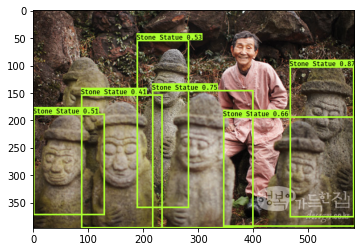

./images/Stone_statue_ (40).jpg
(416, 416, 3)
Found 1 boxes for img
Stone Statue 1.00 (96, 49) (581, 1010)
Time spent: 0.142sec


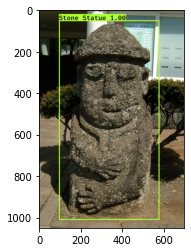

./images/Stone_statue_ (153).jpg
(416, 416, 3)
Found 1 boxes for img
Stone Statue 1.00 (40, 14) (150, 268)
Time spent: 0.117sec


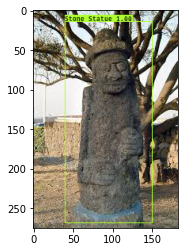

./images/Stone_statue_ (197).jpg
(416, 416, 3)
Found 1 boxes for img
Stone Statue 0.99 (38, 53) (114, 182)
Time spent: 0.094sec


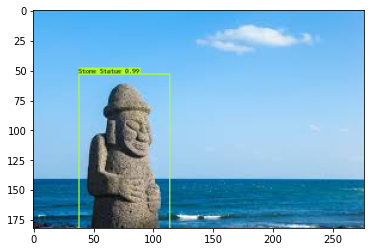

./images/Stone_statue_ (78).jpg
(416, 416, 3)
Found 2 boxes for img
Stone Statue 0.55 (46, 59) (89, 165)
Stone Statue 0.59 (180, 59) (228, 150)
Time spent: 0.097sec


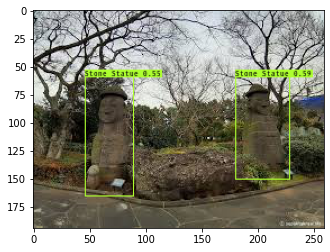

In [ ]:
for test_image in reserve_for_testing:
  test_image_path = test_image.split(' ')[0]+str(' ')+test_image.split(' ')[1]
  detect_image(test_image_path, yolo_model)